# Lab Session \# 05


---


by Josué Obregón <br>
BDA712-00 - Machine Learning Programming <br>
Department of Big Data Analytics - Kyung Hee University<br>

## Objective

The objective of this session is to work on top of our previous linear regression implementation and add the ability to classify to our program. 


# Getting the data

In [1]:
import gdown

In [2]:
!mkdir data

In [3]:
urls = ['https://drive.google.com/uc?export=download&id=14sLAngQszmRpO4bdX9FTT0XcVv4_5wdT', # pizza.txt  https://drive.google.com/file/d/14sLAngQszmRpO4bdX9FTT0XcVv4_5wdT/view?usp=sharing       
      ]
outputs = ['police.txt']
for url,output in zip(urls,outputs):
  gdown.download(url, f'data/{output}', quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=14sLAngQszmRpO4bdX9FTT0XcVv4_5wdT
To: /content/data/police.txt
100%|██████████| 431/431 [00:00<00:00, 397kB/s]


# Preliminaries

Let's import the data and prepare the variables that we will need for our laboratory

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data = np.genfromtxt('data/police.txt', delimiter=',', skip_header=1)
X, Y = data[:,:3], data[:,-1]
X = np.column_stack((np.ones(X.shape[0]), X))
Y = Y.reshape(-1,1)
print(X.shape)
print(Y.shape)

(30, 4)
(30, 1)


Let’s take a look at Roberto’s file. To make our life easier, let’s ignore the
“Temperature” and “Tourists” columns for now, and just plot the “Reservations”
column against the label, as shown in the graph that follows:

Text(0, 0.5, 'Police call')

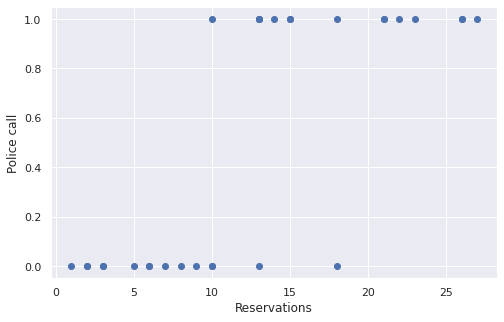

In [6]:
sns.set()

plt.figure(figsize=(8,5))

# plot the points
plt.scatter(X[:,1], Y)

plt.xlabel('Reservations')
plt.ylabel('Police call')

Does linear regression works?

As we discuseed previously in our class, linear regression isn’t a good fit for categorical data such as these. Let’s look for a model that is.

# Implementing the sigmoid function

Let’s start by looking back at $\hat{y}$, the weighted sum of the inputs that we
introduced in our last laboratory.

* $\hat{y} =  \beta_0x_0 *  + \beta_1 x_1 + \beta_2 * x_2 + \beta_3 x_3 + ...$


In linear regression, $\hat{y}$ could take any value. Binary classification, however, imposes a tight constraint: $\hat{y}$ must not drop below 0, nor raise above 1. 

Why?

We just learned how this works.

We model the right side of the equation equal to the log of the odds (log-odds) of the probability of obtaining a police call. That is:

  $log(\frac{p}{1-p})=\beta_0x_0 *  + \beta_1 x_1 $

where $p=P(Y=1|X)$

And we also learned that by rearranging that equation, we can obtain the estimate of the conditional probability of geting a police call, looking like this:

  $\hat{p}(Y=1)=\frac{e^{\beta_0x_0 *  + \beta_1 x_1}}{1+e^{\beta_0x_0 *  + \beta_1 x_1}}$

I think you already guessed that the function that we should apply to the right our original equation should be the sigmoid function.

  $\sigma(z)=\frac{1}{1+e^{-z}}$

which can be also rewritten as:

  $\sigma(z)=\frac{e^{z}}{1+e^{z}}$



**** erase

check ppt to talk about desirable characteristics of sigmoid

\## Logistic (sigmoid) function

Let's first define our sigmoid function 

In [7]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

As usual with NumPy-based functions, sigmoid() takes advantage of broadcasting: the z argument can be a number, or a multidimensional array. In the second case, the function will return an array that contains the sigmoids of all the elements of z.

Try it out!

In [8]:
val1 = 5
var2 = np.array([5,6,7])

In [9]:
sigmoid(var2)

array([0.99330715, 0.99752738, 0.99908895])

Let's check the prediction code—the point where we used to calculate
the weighted sum. The original function looked like this:
```python
def predict(X, w):
  return np.matmul(X, w)
```

Let's update this function. Additionally, let's use the name `forward` instead of `predict`. 

    Note: Later in the course, we’ll see that this process of moving data through the system is also called forward propagation.

In [10]:
def forward(X, beta):
  weight_sum = np.matmul(X, beta)
  return sigmoid(weight_sum)

The result of forward() is our prediction $\hat{y}$, that is a matrix with the same dimensions as the weighted sum: one row per example, and one column.

Only, each element in the matrix is now constrained between 0 and 1.

Intuitively, you can see the values of $\hat{y}$ as forecasts that can be more or less certain. If a value is close to the extremes, like 0.01 or 0.98, that’s a highly confident forecast. If it’s close to the middle, like 0.51, that’s a very uncertain forecast.

During the `training phase`, that gradual variation in confidence is just what we
need. We want the loss to change smoothly, so that we can slide over it with
gradient descent. 

Once we switch from the `training phase` to the `prediction phase`, however, we would like the labels that we used for training the classifier (0 or 1) to be returned, so the classification should also be a straight 0 or 1.

But let's add an extra parameter to indicate the function if we want to return the probabilities.

In [11]:
def predict(X, beta, return_proba = True):
  if return_proba:
    return forward(X, beta)
  else : 
    return np.round(forward(X, beta))

Alright, it seems that we’re making great progress toward a classification program...

except for a minor difficulty that we’re about to face.

## Smoothing the loss function

By adding the sigmoid to our program, we introduced a subtle problem: 

We made gradient descent less reliable. The problem happens when we update
the loss() function in our system to use the new classification code:

```python 
def mse_loss(X, Y, beta):
  return np.average((forward(X, beta) - Y) ** 2)
```

At first glance, this function is almost identical to the loss() function that we had before: the `mean squared error` of the predictions compared with the
actual labels. 

The only difference from the previous `loss()` is that the function
that calculates the predicted labels $\hat{y}$ has changed, from `predict()` to `forward()`.


In [12]:
def mse_loss(X, Y, beta):
    return np.average((forward(X, beta) - Y) ** 2)

In [13]:
def prepare_axes(figsize=(10,8), fontsize=15):
    ax = plt.figure(figsize=figsize).gca(projection="3d")
    ax.clear()
    ax.set_zticklabels(())
    ax.set_xlabel(r'$\beta_{1}$', labelpad=15, fontsize=fontsize)
    ax.set_ylabel(r'$\beta_{2}$', labelpad=15, fontsize=fontsize)
    ax.set_zlabel('Loss', labelpad=15, fontsize=fontsize)
    ax.view_init(30, 120)
    return ax

In [14]:
# Come up with some plausible data
n_examples = 20
np.random.seed(1234)
X2 = np.random.rand(n_examples, 2)
beta2 = [1.23, 2.34]
Y2 = np.dot(X2, beta2)
Y_binary = np.greater_equal(Y2, np.median(Y2)).astype(int)

In [15]:
# Prepare plot
from matplotlib import cm
MESH_SIZE = 400
sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})

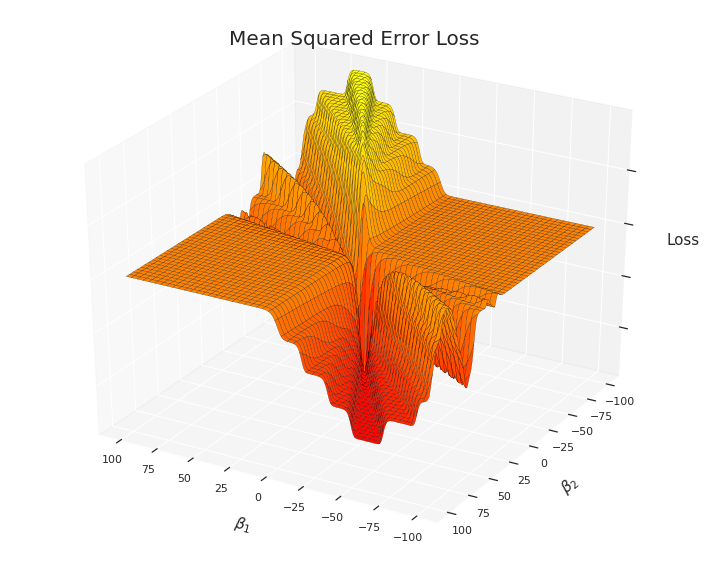

In [16]:
# Plot mean squared error loss
ax = prepare_axes()
plt.title("Mean Squared Error Loss", fontsize=20)
view_range = 100    # Wide range to see the creeks and valleys
B1, B2 = np.meshgrid(np.linspace(-view_range, view_range, MESH_SIZE),
                     np.linspace(-view_range, view_range, MESH_SIZE))
losses = np.array([mse_loss(X2, Y_binary, [b1, b2]) for b1, b2
                   in zip(np.ravel(B1), np.ravel(B2))])
L = losses.reshape((MESH_SIZE, MESH_SIZE))
ax.plot_surface(B1, B2, L, cmap=cm.autumn, edgecolors='black',
                vmax=np.max(L), linewidth=0.2, antialiased=True)
plt.tight_layout()
plt.show()

Looks like we have a problem here. See those deep canyons leading straight into holes? We mentioned those holes when we introduced gradient descent—they’re the dreaded local minima.

Let's look for another loss function!

Afther that long explanation, let's define our `log-loss` function. 

$L(y_{\beta}(x))=-\frac{1}{n} \sum_{i=1}^{n} (y \cdot log(y_{\beta}(x)) + ( (1-y) \cdot log(1-y_{\beta}(x))  $

And the gradient is defined as:

* $-\frac{\partial{L}}{\partial{\beta}}=\frac{1}{n} \sum_{i=1}^{n} x^{(i)}(y_{\beta}(x^{(i)}) - y^{(i)})$

Let's code first the `log-loss` functionit:

In [40]:
def log_loss(X, Y, beta):
  y_hat = forward(X, beta)
  first_term = Y*np.log(y_hat)
  second_term = (1-Y)*np.log(1-y_hat)
  return -np.mean(first_term + second_term)

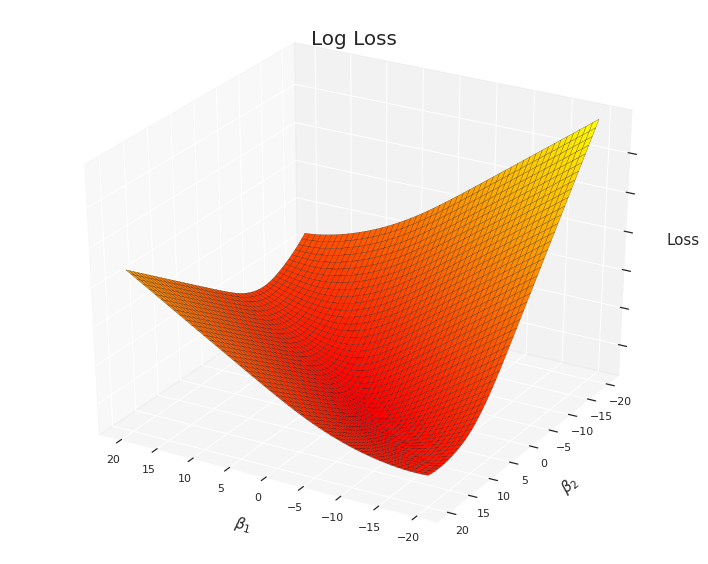

In [41]:
# Plot logarithmic loss
ax = prepare_axes()
plt.title("Log Loss", fontsize=20)
view_range = 20    # Tight range to avoid overflows
B1, B2 = np.meshgrid(np.linspace(-view_range, view_range, MESH_SIZE),
                     np.linspace(-view_range, view_range, MESH_SIZE))
losses = np.array([log_loss(X2, Y_binary, [b1, b2]) for b1, b2
                   in zip(np.ravel(B1), np.ravel(B2))])
L = losses.reshape((MESH_SIZE, MESH_SIZE))
ax.plot_surface(B1, B2, L, cmap=cm.autumn, edgecolors='black',
                vmax=np.max(L), linewidth=0.2, antialiased=True)
plt.tight_layout()
plt.show()

Now let's modify our gradient. Remember how our previous function looked like:

```python
def gradient(X, Y, w):
  return 2 * np.matmul(X.T, (predict(X, w) - Y)) / X.shape[0]
```

Let's code it, and update the name of the parameters to beta

In [42]:
def gradient(X, Y, beta):
  return 2 * np.matmul(X.T, (forward(X,beta)-Y)) / X.shape[0]

Before we can try our code, let's define again our train function. It is the same as for our previous Lab session, so you can just run the following code.

In [43]:
def train(X, Y, iterations, lr=0.001,  precision = 1e-6, print_step=5000):
  beta = np.zeros((X.shape[1], 1))
  previous_loss = log_loss(X, Y, beta)
  for i in range(iterations):
    if i % print_step == 0:
      print(f'Iteration {i} => Loss(Log-loss){previous_loss:.6f}')
    beta -= gradient(X, Y, beta) * lr

    current_loss = log_loss(X, Y, beta)
    if (abs(current_loss - previous_loss)) < precision:
      print(f'Early stop at iteration {i}')
      return beta
    previous_loss = current_loss
  
  return beta

In [104]:
beta = train(X, Y, iterations=100000, lr=0.01, precision=1e-20, print_step=5000)

Iteration 0 => Loss(Log-loss)0.693147
Iteration 5000 => Loss(Log-loss)0.298603
Iteration 10000 => Loss(Log-loss)0.263901
Iteration 15000 => Loss(Log-loss)0.245840
Iteration 20000 => Loss(Log-loss)0.235148
Iteration 25000 => Loss(Log-loss)0.228223
Iteration 30000 => Loss(Log-loss)0.223443
Iteration 35000 => Loss(Log-loss)0.219986
Iteration 40000 => Loss(Log-loss)0.217397
Iteration 45000 => Loss(Log-loss)0.215403
Iteration 50000 => Loss(Log-loss)0.213833
Iteration 55000 => Loss(Log-loss)0.212576
Iteration 60000 => Loss(Log-loss)0.211553
Iteration 65000 => Loss(Log-loss)0.210711
Iteration 70000 => Loss(Log-loss)0.210010
Iteration 75000 => Loss(Log-loss)0.209422
Iteration 80000 => Loss(Log-loss)0.208923
Iteration 85000 => Loss(Log-loss)0.208499
Iteration 90000 => Loss(Log-loss)0.208134
Iteration 95000 => Loss(Log-loss)0.207820


For visualization purposes, lets train our model just with one variable, and let's visualize it for hard and soft predictions.

In [81]:
X1 = data[:, :1]
X1 = np.column_stack((np.ones(X1.shape[0]), X1))
beta_1 = train(X1, Y, iterations=100000, lr=0.01, precision=1e-20, print_step=5000)

Iteration 0 => Loss(Log-loss)0.693147
Iteration 5000 => Loss(Log-loss)0.299667
Iteration 10000 => Loss(Log-loss)0.292902
Iteration 15000 => Loss(Log-loss)0.291839
Iteration 20000 => Loss(Log-loss)0.291611
Iteration 25000 => Loss(Log-loss)0.291556
Iteration 30000 => Loss(Log-loss)0.291543
Iteration 35000 => Loss(Log-loss)0.291539
Iteration 40000 => Loss(Log-loss)0.291538
Iteration 45000 => Loss(Log-loss)0.291538
Iteration 50000 => Loss(Log-loss)0.291538
Iteration 55000 => Loss(Log-loss)0.291538
Iteration 60000 => Loss(Log-loss)0.291538
Iteration 65000 => Loss(Log-loss)0.291538
Iteration 70000 => Loss(Log-loss)0.291538
Iteration 75000 => Loss(Log-loss)0.291538
Iteration 80000 => Loss(Log-loss)0.291538
Iteration 85000 => Loss(Log-loss)0.291538
Early stop at iteration 88715


### Visualizing soft predictions

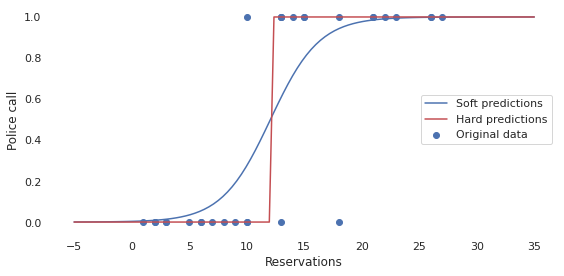

In [85]:
x_test = np.linspace(-5,35,100)
x_test = np.column_stack((np.ones(x_test.shape[0]), x_test))


plt.figure(figsize=(8,4))
plt.scatter(X[:,1], Y, label='Original data') # This line generates the scatter plot only with the second feature (index 1) which is the number of reservations

## write the code to plot the soft predictions first
# plt.scatter(X[:,1], forward(X1, beta_1), label='Soft predictions')
plt.plot(x_test[:,1], predict(x_test, beta_1, return_proba=True), c='b', label='Soft predictions')
plt.plot(x_test[:,1], predict(x_test, beta_1, return_proba=False), c='r', label='Hard predictions')
##


plt.xlabel('Reservations')
plt.ylabel('Police call')
plt.legend(loc='center right')
plt.tight_layout()

In [66]:
x_test

array([[ 1.        , -5.        ],
       [ 1.        , -4.5959596 ],
       [ 1.        , -4.19191919],
       [ 1.        , -3.78787879],
       [ 1.        , -3.38383838],
       [ 1.        , -2.97979798],
       [ 1.        , -2.57575758],
       [ 1.        , -2.17171717],
       [ 1.        , -1.76767677],
       [ 1.        , -1.36363636],
       [ 1.        , -0.95959596],
       [ 1.        , -0.55555556],
       [ 1.        , -0.15151515],
       [ 1.        ,  0.25252525],
       [ 1.        ,  0.65656566],
       [ 1.        ,  1.06060606],
       [ 1.        ,  1.46464646],
       [ 1.        ,  1.86868687],
       [ 1.        ,  2.27272727],
       [ 1.        ,  2.67676768],
       [ 1.        ,  3.08080808],
       [ 1.        ,  3.48484848],
       [ 1.        ,  3.88888889],
       [ 1.        ,  4.29292929],
       [ 1.        ,  4.6969697 ],
       [ 1.        ,  5.1010101 ],
       [ 1.        ,  5.50505051],
       [ 1.        ,  5.90909091],
       [ 1.        ,

At a glance, you can tell that this curved shape fits the data better than a line ever could. It is very similar at the graphs we saw in the lecture notes using the default data.

To be clear, this diagram have nothing to do with the loss curves that we seen before (sigmoid function). This plot visualize the model, while the earlier plots visualized the loss of the model. Even if these two functions are different, however, they’re related. 

### Visualizing hard predictions

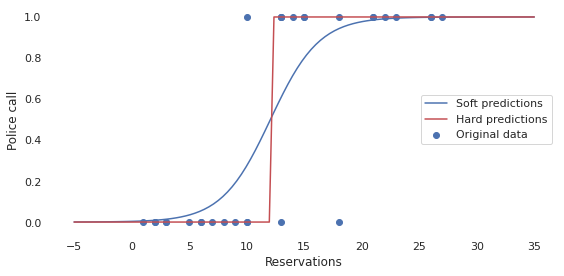

In [86]:
x_test = np.linspace(-5,35,100)
x_test = np.column_stack((np.ones(x_test.shape[0]), x_test))


plt.figure(figsize=(8,4))
plt.scatter(X[:,1], Y, label='Original data') # This line generates the scatter plot only with the second feature (index 1) which is the number of reservations

## write the code to plot the soft predictions first
# plt.scatter(X[:,1], forward(X1, beta_1), label='Soft predictions')
plt.plot(x_test[:,1], predict(x_test, beta_1, return_proba=True), c='b', label='Soft predictions')
plt.plot(x_test[:,1], predict(x_test, beta_1, return_proba=False), c='r', label='Hard predictions')
##


plt.xlabel('Reservations')
plt.ylabel('Police call')
plt.legend(loc='center right')
plt.tight_layout()

This function results in a sharper shape, because the function only predicts ones or zeros. 

### Visualizing the fitted surface using 2 variables

When you add another input variable, the model function looks similar—but
now it’s three-dimensional

In [90]:
beta_2 = train(X[:, :3], Y, iterations=100000, lr=0.01)
print(beta_2)

Iteration 0 => Loss(Log-loss)0.693147
Iteration 5000 => Loss(Log-loss)0.328956
Iteration 10000 => Loss(Log-loss)0.295722
Iteration 15000 => Loss(Log-loss)0.278254
Iteration 20000 => Loss(Log-loss)0.267918
Iteration 25000 => Loss(Log-loss)0.261269
Early stop at iteration 26064
[[-7.82098988]
 [ 0.3131462 ]
 [ 0.19891951]]


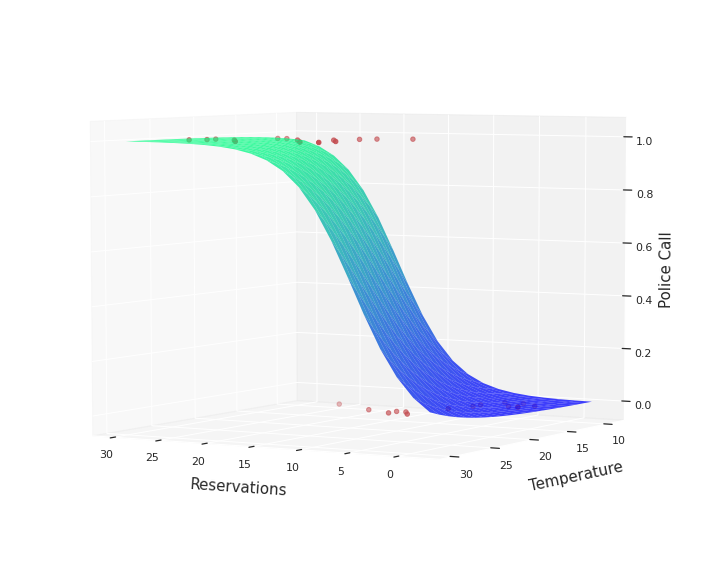

In [91]:
# Plot the axes
sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})
ax = plt.figure(figsize=(10,8)).gca(projection="3d")
ax.view_init(5, 120)
ax.set_xlabel("Reservations", labelpad=15, fontsize=15)
ax.set_ylabel("Temperature", labelpad=15, fontsize=15)
ax.set_zlabel("Police Call", labelpad=5, fontsize=15)

# Plot the data points
x1 = X[:,1]
x2 = X[:,2]
ax.scatter(x1, x2, Y, color='r')

# Plot the model
MARGIN = 3
MESH_SIZE = 20
x, y = np.meshgrid(np.linspace(x1.min() - MARGIN, x1.max() + MARGIN, MESH_SIZE),
                   np.linspace(x2.min() - MARGIN, x2.max() + MARGIN, MESH_SIZE))
z = np.array([predict(np.column_stack(([1], [i], [j])), beta_2, return_proba=True) for i, j in zip(np.ravel(x), np.ravel(y))])
z = z.reshape((MESH_SIZE, MESH_SIZE))
ax.plot_surface(x, y, z, alpha=0.75, cmap=cm.winter,
                linewidth=0, antialiased=True, color='black')

plt.tight_layout()
plt.show()

Let's write a new `test()` function that prints the percentage of correct classifications. 


In [95]:
X.shape[0]

30

In [108]:
def test(X, Y, beta):
  n = X.shape[0]
  tp = (predict(X, beta, return_proba=False)==Y).astype(int).sum()
  accuracy = tp/n
  print(f'Accuracy ; {accuracy:.2f}%')


In [109]:
test(X, Y, beta)

Accuracy ; 0.90%


## Summary

In this lab session we walked through binary classification: learning and forecasting data that have a binary label. 

* Linear regression doesn’t work well with categorical values, so we introduced a new algorithm, classification, to deal with them.

* Classification is founded on a function called the `logistic function`, or the `sigmoid`. 

* During `training`, we used the sigmoid to squeeze any value
into the range from 0 to 1. 

* During `prediction`, we clipped the sigmoid to its
nearest binary value—either 0 or 1—to deliver an unambiguous classification.

* In linear regression, we used the mean squared error to calculate the loss.
Once you add the sigmoid to the recipe, however, the mean squared error’s
surface becomes bumpy, and hostile to gradient descent.

* So we switched to an alternative loss function that works well with the sigmoid, called the log loss.

The next week will be a breakthrough. Now that we know about classification, we’re about to apply it to an exciting real-world problem: image recognition. 

Will our tiny program still work when confronted with that?

